### **Haremos una extracción y análisis de los datos que vamos a extraer de la API**

* Los datos los vamos a extraer a partir de track_id que esta en el *csv* **spotify_dataset_cleaned**

* Esto se hará para encontrar el ID del artista, el nombre, los seguidores y la popularidad.

Y crearemos un csv a partir de la extracción de la api con la siguiente estructura:

+ artist_id 
+ track_id
+ artist_popularity
+ artist_followers
+ artist_name

Sabemos que en **spotify_dataset.csv** está el nombre de los artistas en la columna **artists**. Sin embargo, esta columna tiene varios nombres de artistas y no solo un nombre, nosotros con la columna *artist_name* lo que buscamos son los nombres **individuales** de cada artista

In [2]:
import pandas as pd
import spotipy
import os
import time
import logging
from dotenv import load_dotenv
from tqdm import tqdm
from spotipy import SpotifyClientCredentials
from requests.exceptions import ReadTimeout, ConnectionError
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
print(os.getcwd())

try:
    os.chdir("../../workshop_02")

except FileNotFoundError:
    print("Directory not found or already exists.")
    
print(os.getcwd())

/home/edwards/Documentos/university/etl/workshop_02/notebooks
/home/edwards/Documentos/university/etl/workshop_02


In [3]:
# Credenciales
SPOTIFY_CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID")
SPOTIFY_CLIENT_SECRET = os.getenv("SPOTIFY_CLIENT_SECRET")
url = "https://gabrieledwards.site/"

Las credenciales están **lógicamente ocultas**

In [4]:
import os
import time
import logging
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv
from spotipy import SpotifyClientCredentials, SpotifyException
from requests.exceptions import ReadTimeout, ConnectionError

load_dotenv("env/.env")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

ORIGINAL_DATASET_PATH = "data/spotify_dataset.csv"
OUTPUT_CSV = "data/api_artist.csv"
TRACK_ID_COLUMN = "track_id"
BATCH_SIZE = 50
REQUEST_DELAY_SECONDS = 0.5

def setup_spotify_client():
    try:
        client_credentials_manager = SpotifyClientCredentials(
            client_id=os.getenv("SPOTIFY_CLIENT_ID"),
            client_secret=os.getenv("SPOTIFY_CLIENT_SECRET")
        )
        sp = spotipy.Spotify(
            client_credentials_manager=client_credentials_manager,
            requests_timeout=15,
            retries=5,
            status_retries=5,
            backoff_factor=0.3
        )
        sp.search(q='test', type='track', limit=1)
        logging.info("Spotify client configured and connection tested.")
        return sp
    except Exception:
        logging.error("Error setting up Spotify client. Check credentials in .env")
        raise

def extract_artist_info_per_track(sp_client, original_dataset_path, output_filepath, track_id_col):
    try:
        df_original_ids = pd.read_csv(original_dataset_path, usecols=[track_id_col])
        logging.info(f"Original file '{original_dataset_path}' read for IDs.")
    except FileNotFoundError:
        logging.error(f"File '{original_dataset_path}' not found.")
        return

    track_ids = df_original_ids[track_id_col].dropna().unique().tolist()
    logging.info(f"Processing {len(track_ids)} unique track IDs.")
    artist_data_results = []
    cache = {}

    for i in tqdm(range(0, len(track_ids), BATCH_SIZE), desc="Processing Track Batches"):
        batch_track_ids = track_ids[i : i + BATCH_SIZE]
        try:
            time.sleep(REQUEST_DELAY_SECONDS)
            track_results = sp_client.tracks(batch_track_ids)
            artist_id_map_batch = {}
            artist_ids_to_fetch = set()

            if track_results and track_results['tracks']:
                for track_info in track_results['tracks']:
                    if track_info and track_info['id'] and track_info['artists']:
                        primary_artist = track_info['artists'][0]
                        if primary_artist and primary_artist['id']:
                            artist_id = primary_artist['id']
                            track_id = track_info['id']
                            artist_name = primary_artist.get('name', None)
                            artist_id_map_batch[track_id] = (artist_id, artist_name)
                            artist_ids_to_fetch.add(artist_id)

            artist_details_map_batch = {}
            if artist_ids_to_fetch:
                unique_artist_ids_list = list(artist_ids_to_fetch)
                for j in range(0, len(unique_artist_ids_list), BATCH_SIZE):
                    sub_batch_artist_ids = unique_artist_ids_list[j : j + BATCH_SIZE]
                    time.sleep(REQUEST_DELAY_SECONDS)
                    artist_results = sp_client.artists(sub_batch_artist_ids)
                    if artist_results and artist_results['artists']:
                        for artist_info in artist_results['artists']:
                            if artist_info and artist_info['id']:
                                followers = artist_info.get('followers', {}).get('total', None)
                                popularity = artist_info.get('popularity', None)
                                artist_details_map_batch[artist_info['id']] = (followers, popularity)

            for original_track_id in batch_track_ids:
                artist_info = artist_id_map_batch.get(original_track_id, (None, None))
                artist_id, artist_name = artist_info
                followers, popularity = None, None
                if artist_id:
                    followers, popularity = artist_details_map_batch.get(artist_id, (None, None))
                artist_data_results.append({
                    'track_id': original_track_id,
                    'artist_id': artist_id,
                    'artist_name': artist_name,
                    'artist_followers': followers,
                    'artist_popularity': popularity
                })

        except (SpotifyException, ReadTimeout, ConnectionError) as e:
            if isinstance(e, SpotifyException) and e.http_status == 429:
                retry_after = int(e.headers.get('Retry-After', REQUEST_DELAY_SECONDS))
                logging.warning(f"Rate limit exceeded. Retrying after {retry_after} seconds.")
                time.sleep(retry_after)
            else:
                logging.warning(f"Error processing track batch {i}. Skipping.")
                time.sleep(5)

    if not artist_data_results:
        logging.warning("No results generated.")
        return

    df_final = pd.DataFrame(artist_data_results)
    logging.info(f"Processing completed. Total records: {len(df_final)}")
    output_dir = os.path.dirname(output_filepath)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    df_final.to_csv(output_filepath, index=False, encoding='utf-8')
    logging.info(f"Track-to-artist file saved at: '{output_filepath}'")

if __name__ == "__main__":
    logging.info("Starting track-to-artist extraction script...")
    start_time = time.time()
    sp = setup_spotify_client()
    if sp:
        extract_artist_info_per_track(sp, ORIGINAL_DATASET_PATH, OUTPUT_CSV, TRACK_ID_COLUMN)
    end_time = time.time()
    logging.info(f"Script finished. Total time: {end_time - start_time:.2f} seconds.")

2025-04-12 19:27:39,248 - INFO - Starting track-to-artist extraction script...


2025-04-12 19:27:40,109 - INFO - Spotify client configured and connection tested.
2025-04-12 19:27:40,527 - INFO - Original file 'data/spotify_dataset.csv' read for IDs.
2025-04-12 19:27:40,591 - INFO - Processing 89741 unique track IDs.
Processing Track Batches: 100%|██████████| 1795/1795 [49:28<00:00,  1.65s/it] 
2025-04-12 20:17:09,125 - INFO - Processing completed. Total records: 89741
2025-04-12 20:17:09,661 - INFO - Track-to-artist file saved at: 'data/api_artist.csv'
2025-04-12 20:17:09,733 - INFO - Script finished. Total time: 2970.48 seconds.


Como vemos va la API va a realizar 1795 batches, debido a que solo se pueden hacer **50 peticiones** a la **api de spotify** al mismo tiempo, por lo que **1795 * 50 = 89750** y nosotros tenemos 89741 datos en el dataset **spotify_cleaned_dataset** lo cual es lógico. 

In [4]:
INPUT_CSV_PATH = "data/api_artist.csv"

print(f"Cargando datos desde: {INPUT_CSV_PATH}")
if not os.path.exists(INPUT_CSV_PATH):
    print(f"Error: El archivo no se encontró en la ruta: '{INPUT_CSV_PATH}'")
else:
    try:
        df = pd.read_csv(INPUT_CSV_PATH)
        print("Datos cargados exitosamente.")
    except Exception as e:
        print(f"Error al cargar el archivo CSV: {e}")

Cargando datos desde: data/api_artist.csv
Datos cargados exitosamente.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89741 entries, 0 to 89740
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   track_id           89741 non-null  object
 1   artist_id          89741 non-null  object
 2   artist_name        89573 non-null  object
 3   artist_followers   89741 non-null  int64 
 4   artist_popularity  89741 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.4+ MB


Vemos que tenemos un dato con int64, lo cambiaremos a int32 para que python los tome con mas facilidad

In [6]:
# Convert int64 columns to int32
df['artist_followers'] = df['artist_followers'].astype('int32')
df['artist_popularity'] = df['artist_popularity'].astype('int32')

In [8]:
pd.set_option('display.float_format', '{:,.2f}'.format)
df.describe()

,artist_followers,artist_popularity
count,"89,741.00","89,741.00"
mean,"3,000,521.16",52.44
std,"10,182,825.84",18.69
min,0.00,0.00
25%,"39,891.00",41.00
50%,"239,159.00",54.00
75%,"1,397,909.00",66.00
max,"142,469,822.00",100.00


visualizamos los datos para tener mejor comprensión de lo que estamos haciendo

In [36]:
df.head()

,track_id,artist_id,artist_followers,artist_popularity
0,5SuOikwiRyPMVoIQDJUgSV,1S2S00lgLYLGHWA44qGEUs,2096701,65
1,4qPNDBW1i3p13qLCt0Ki3A,142VT1MtWzaD13CnOiKFDn,22524,44
2,1iJBSr7s7jYXzM8EGcbK5b,2vm8GdHyrJh2O2MfbQFYG0,803297,57
3,6lfxq3CG4xtTiEg7opyCyx,7h4j9YTJJuAHzLCc3KCvYu,521097,61
4,5vjLSffimiIP26QG5WcN2K,5D3muNJhYYunbRkh3FKgX0,348149,64


Si revisamos *spotify_dataset_cleaned.csv* vemos que coinciden los datos de las primeras 5 columnas

In [9]:
df.isnull().sum()

track_id               0
artist_id              0
artist_name          168
artist_followers       0
artist_popularity      0
dtype: int64

Tal parece que existen valores nulos en el artist_name, vamos a ver que sucede

In [14]:
for column in df.columns:
    duplicados = df[column].duplicated().sum()
    print(f"Columna '{column}': {duplicados} valores duplicados")

Columna 'track_id': 0 valores duplicados
Columna 'artist_id': 71895 valores duplicados
Columna 'artist_name': 71981 valores duplicados
Columna 'artist_followers': 73305 valores duplicados
Columna 'artist_popularity': 89642 valores duplicados


Hay algo bueno aquí y es que los valores en track_id no se repiten, es decir que las canciones no se repeten. El resto de columnas si lo pueden hacer debido a que un artista puede tener más de una sola canción y repetirse varias veces en el dataframe.

In [ ]:
nulos_artist_name = df[df['artist_name'].isna()]
print(nulos_artist_name[['track_id', 'artist_id', 'artist_followers', 'artist_popularity']])

Filas con artist_name nulo:
                     track_id               artist_id  artist_followers  \
3439   5jq2ArI1hhZ3wlJN8RijD3  0LyfQWJT6nXafLPZqxe9Of           2683027   
15248  4GaTyDp4257sMSNbNXIlMW  0LyfQWJT6nXafLPZqxe9Of           2683027   
15384  6N6ESDWoc9yeF8CvKWKxYg  0LyfQWJT6nXafLPZqxe9Of           2683027   
15390  4piMfKVoPcY06x4hTLf9Pl  0LyfQWJT6nXafLPZqxe9Of           2683027   
15424  0JiPUFfWlhT1SJ92eZ84GU  0LyfQWJT6nXafLPZqxe9Of           2683027   
...                       ...                     ...               ...   
75919  4UD3cf8rKv6pKrM7IL5EUZ  0LyfQWJT6nXafLPZqxe9Of           2683027   
78918  1ODitWwCi2P2D489FX5CmY  0LyfQWJT6nXafLPZqxe9Of           2683027   
78942  7A4FSWQfxmDY2nqLRk4g8f  0LyfQWJT6nXafLPZqxe9Of           2683027   
78950  7r0YNXexEsShOd39hql2W9  0LyfQWJT6nXafLPZqxe9Of           2683027   
87924  7GPBOpYrsIKnvW5T6gG5hl  0LyfQWJT6nXafLPZqxe9Of           2683027   

       artist_popularity  
3439                   0  
15248            

Cuando revisamos las filas que tienen valores nulos, nos damos cuenta de que mantienen el mismo ID, y la popularidad se mantienen en cero, pero parece que al buscarlo en internet se trata de Various Artists, lo cual como en el EDA de grammys explicamos, es una colección de canciones que no pertenecen a un solo artista sino a varios, por lo que colocar una popularidad general no tendría sentido y por eso se mantiene en cero.

Nota: **No logro entender porque spotify no tomo el nombre de Various Artist y solo lo coloco como nulo** pero teniendo en cuenta esto, podemos agregar el nombre a estos valores nulos

In [16]:
df['artist_name'] = df['artist_name'].fillna("Various Artists")

In [17]:
df['artist_name'].isna().sum()

0

Luego del cambio no quedan nulos y el dataset ahora tiene coherencia

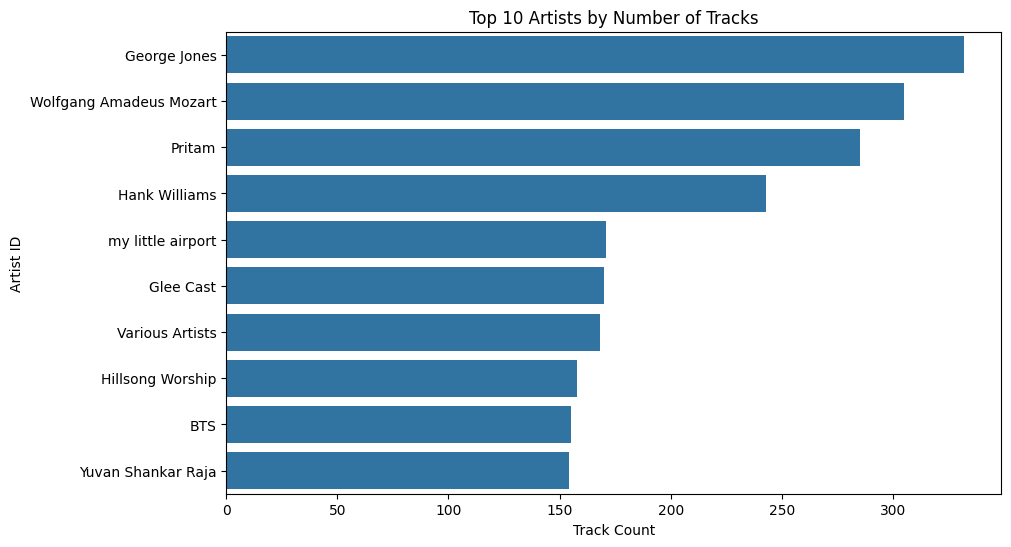

Top 10 artists by number of tracks:
               artist_name  track_count
0             George Jones          332
1  Wolfgang Amadeus Mozart          305
2                   Pritam          285
3            Hank Williams          243
4        my little airport          171
5                Glee Cast          170
6          Various Artists          168
7         Hillsong Worship          158
8                      BTS          155
9       Yuvan Shankar Raja          154


In [18]:
top_tracks = df.groupby('artist_name')['track_id'].count().sort_values(ascending=False).head(10).reset_index(name='track_count')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_tracks, x='track_count', y='artist_name')
plt.title('Top 10 Artists by Number of Tracks')
plt.xlabel('Track Count')
plt.ylabel('Artist ID')
plt.show()

print("Top 10 artists by number of tracks:")
print(top_tracks[['artist_name', 'track_count']])

Como manejamos tanto el nombre como el id del artista, buscamos agrupamos las canciones y el nombre del artista y nos damos cuenta de que el artista con más canciones es **George Jones**

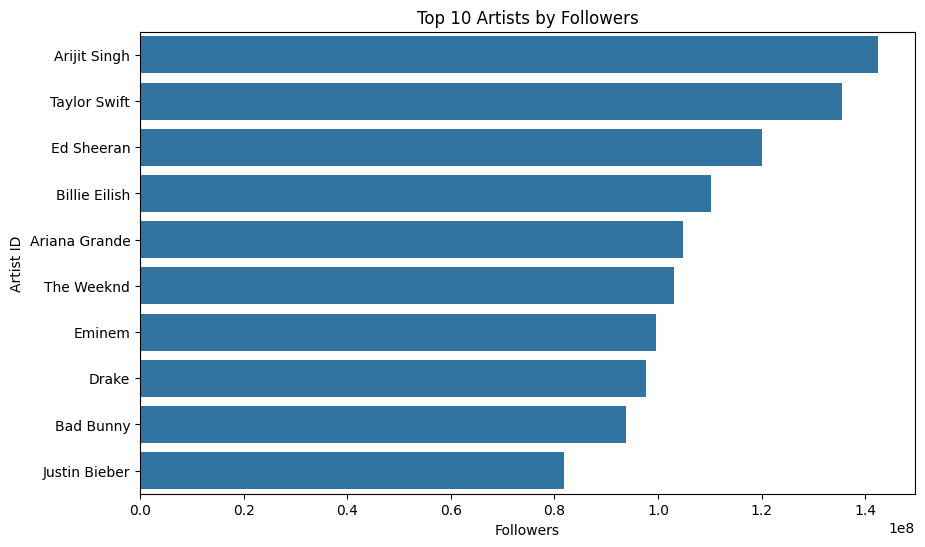

Top 10 artists by followers:
         artist_name  artist_followers
48408   Arijit Singh         142469822
67648   Taylor Swift         135576261
57113     Ed Sheeran         119963069
28406  Billie Eilish         110192304
18914  Ariana Grande         104789146
67618     The Weeknd         103109342
45335         Eminem          99503926
45283          Drake          97693433
19462      Bad Bunny          93790829
19871  Justin Bieber          81786228


In [20]:
top_followers = df[['artist_name', 'artist_followers']].drop_duplicates().sort_values(by='artist_followers', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_followers, x='artist_followers', y='artist_name')
plt.title('Top 10 Artists by Followers')
plt.xlabel('Followers')
plt.ylabel('Artist ID')
plt.show()

print("Top 10 artists by followers:")
print(top_followers[['artist_name', 'artist_followers']])

En este caso queremos saber cual es el artista con más seguidores y nos damos cuenta de que es: **Arijit Singh**

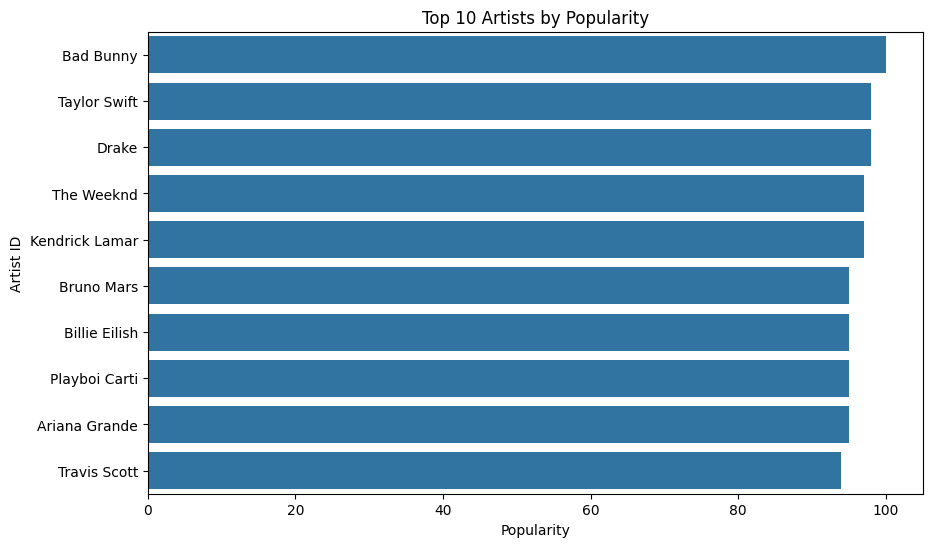

Top 10 artists by popularity:
          artist_name  artist_popularity
19462       Bad Bunny                100
67648    Taylor Swift                 98
45283           Drake                 98
67618      The Weeknd                 97
45519  Kendrick Lamar                 97
18966      Bruno Mars                 95
28406   Billie Eilish                 95
45683   Playboi Carti                 95
18914   Ariana Grande                 95
45472    Travis Scott                 94


In [21]:
top_popularity = df[['artist_name', 'artist_popularity']].drop_duplicates().sort_values(by='artist_popularity', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_popularity, x='artist_popularity', y='artist_name')
plt.title('Top 10 Artists by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Artist ID')
plt.show()

print("Top 10 artists by popularity:")
print(top_popularity[['artist_name', 'artist_popularity']])

Y algo que es de esperar, es que el artista con más popularidad es **Bad Bunny**

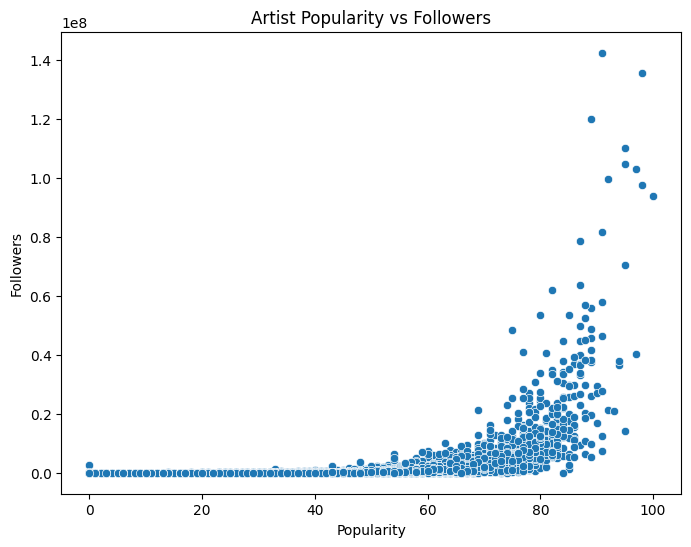

          artist_name  artist_popularity  artist_followers
19462       Bad Bunny                100          93790829
67648    Taylor Swift                 98         135576261
45283           Drake                 98          97693433
67618      The Weeknd                 97         103109342
45519  Kendrick Lamar                 97          40155766


In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df.drop_duplicates('artist_name'), x='artist_popularity', y='artist_followers')
plt.title('Artist Popularity vs Followers')
plt.xlabel('Popularity')
plt.ylabel('Followers')
plt.show()

print(df.drop_duplicates('artist_name')[['artist_name', 'artist_popularity', 'artist_followers']].sort_values(by=['artist_popularity', 'artist_followers'], ascending=False).head(5))

Aquí hacemos unos análisis entre la popularidad y los seguidores y vemos que a si hay una relación bastante notable entre la popularidad y el número de seguidores y vemos que a mayor popularidad mayor número de seguidores exceptuando por algunos artistas con mas de 90 de popularidad y menor seguidores que algunos con 80 puntos de popularidad

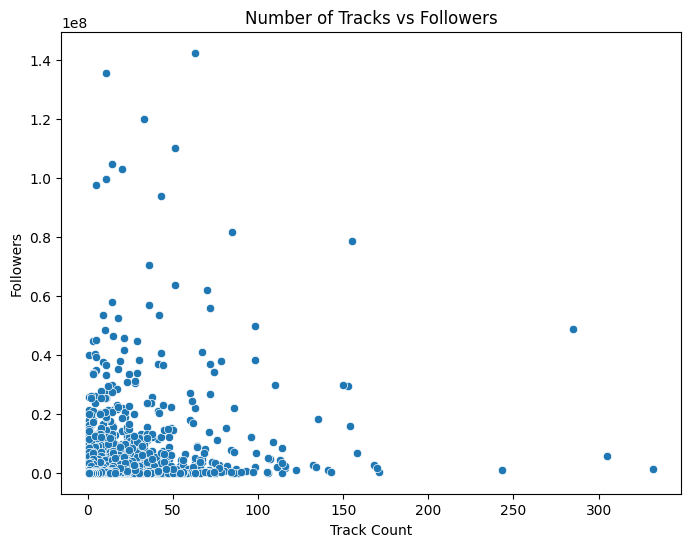

In [23]:
artist_track_counts = df.groupby('artist_name')['track_id'].count().reset_index(name='track_count')
artist_data = df.drop_duplicates('artist_name')[['artist_name', 'artist_followers']].merge(artist_track_counts, on='artist_name')

plt.figure(figsize=(8, 6))
sns.scatterplot(data=artist_data, x='track_count', y='artist_followers')
plt.title('Number of Tracks vs Followers')
plt.xlabel('Track Count')
plt.ylabel('Followers')
plt.show()

Algo interesante en esta parte es que pasa algo muy diferente al gráfico anterior, y esta tiene que ver con la cantidad de canciones de los artistas y lo resumiré de la siguiente manera. "Es mejor 10 canciones buenas que 100 canciones malas", ya que a menor o a número intermedio de canciones mayor número de seguidores.

In [24]:
object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    df[col] = df[col].str.lower().str.strip()

In [25]:
df['artist_followers'] = df['artist_followers'].astype('int32')
df['artist_popularity'] = df['artist_popularity'].astype('int32')

object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    df[col] = df[col].str.lower().str.strip()

output_path = 'data/api_artist.csv'
output_dir = os.path.dirname(output_path)

if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)

df.to_csv(output_path, index=False)

Hacemos una normalización, ajustamos algunos datos antes de volver a guardar el csv otra vez

In [7]:
df.head()

,track_id,artist_id,artist_followers,artist_popularity
0,5suoikwirypmvoiqdjugsv,1s2s00lglylghwa44qgeus,2096701,65
1,4qpndbw1i3p13qlct0ki3a,142vt1mtwzad13cnoikfdn,22524,44
2,1ijbsr7s7jyxzm8egcbk5b,2vm8gdhyrjh2o2mfbqfyg0,803297,57
3,6lfxq3cg4xttieg7opycyx,7h4j9ytjjuahzlcc3kcvyu,521097,61
4,5vjlsffimiip26qg5wcn2k,5d3munjhyyunbrkh3fkgx0,348149,64


Hasta aquí el análisis. Y la única transformación que se hizo fue un cambio en el tipo de datos en followers y popularity